In [6]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
from helper_functions import pred_kernel_parts, gp_predict_fun, hmc_sampling

ModuleNotFoundError: ignored

     |████████████████████████████████| 334 kB 4.9 MB/s 
     |████████████████████████████████| 104 kB 34.4 MB/s 
     |████████████████████████████████| 462 kB 43.4 MB/s 


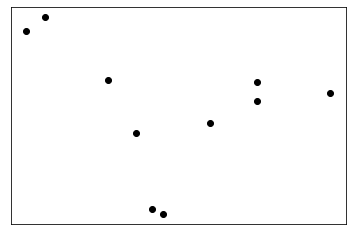

In [ ]:
np.random.seed(9102)
X = np.random.uniform(low=0, high=10, size=10)
Y = np.sin(X) + np.random.normal(scale=0.5, size=10)
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

plt.plot(X, Y, 'ko')
plt.xticks([])
plt.yticks([]);

In [ ]:
k = gpflow.kernels.SquaredExponential()
# k = gpflow.kernels.Matern12()
# k = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

2022-02-01 13:28:04.515518: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


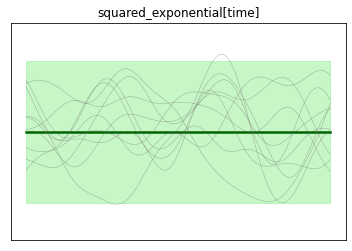

In [ ]:
xx = np.linspace(0, 10, 100).reshape(100, 1)  # test points must be of shape (N, D)

# sample from prior
np.random.seed(9102)
mean = m.mean_function(xx).numpy().flatten()
var = m.kernel.K_diag(xx)
samples = np.random.multivariate_normal(
    mean=m.mean_function(xx).numpy().flatten(), 
    cov=m.kernel(xx),
    size=10)

# ## predict mean and variance of latent GP at test points
# mean, var = m.predict_f(xx)

# ## generate 10 samples from posterior
# tf.random.set_seed(9102)  # for reproducibility
# samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
# plt.figure(figsize=(12, 6))
# plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "darkgreen", lw=2.5)
plt.fill_between(
    xx[:, 0],
     - 1.96 * np.sqrt(var),
     + 1.96 * np.sqrt(var),
    color="lightgreen",
    alpha=0.5,
)

plt.plot(xx, samples.T, "dimgray", linewidth=0.5, alpha=0.5)
plt.ylim(-3, 3)
plt.title('squared_exponential[time]')
plt.xticks([])
plt.yticks([]);

In [ ]:
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)

2022-02-01 13:28:05.063059: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.749872  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.740194  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0379764 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

In [ ]:
# SE = -9.91
# M12 = -10.68
# Per = -12.242
m.log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-9.914289155636961>

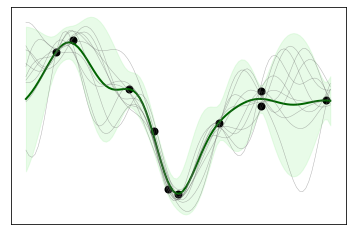

In [ ]:
# Prediction
## generate test points for prediction
xx = np.linspace(0, 10, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
#plt.figure(figsize=(12, 6))
plt.plot(X, Y, "ko", mew=2)
plt.plot(xx, mean, "darkgreen", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="lightgreen",
    alpha=0.2,
)

plt.plot(xx, samples[:, :, 0].numpy().T, "dimgray", linewidth=0.5, alpha=0.5)
plt.xticks([])
plt.yticks([]);

/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


([], [])

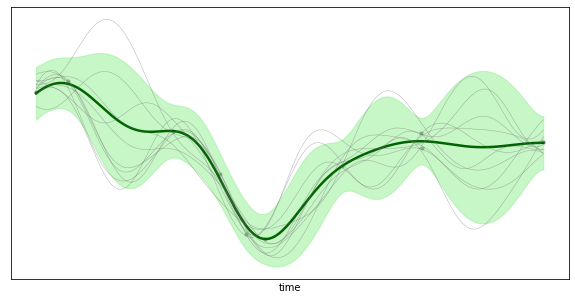

In [ ]:
gp_predict_fun(m, 0, 0, col_names=['time'])
plt.xticks([])
plt.yticks([])

/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Text(0.5, 0, '')

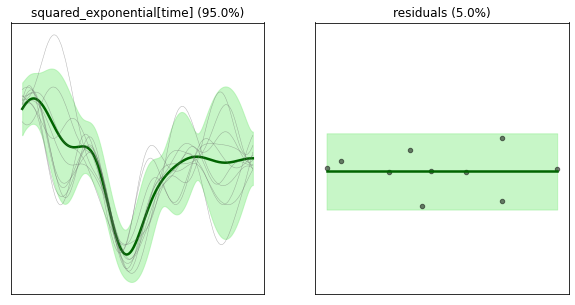

In [ ]:
fig, ax = pred_kernel_parts(m, 'squared_exponential[0]', 0, 0, col_names=['time'])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_xlabel('')
ax[1].set_xlabel('')

In [ ]:
%%time
hmc_out = hmc_sampling(m, samples=500)

CPU times: user 26min 14s, sys: 5.09 s, total: 26min 19s
Wall time: 26min 16s


In [ ]:
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.749872
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.740194
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0379764


In [ ]:
m.trainable_parameters

(<Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.7401937019824303>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.7498722077802528>,
 <Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.03797644835353956>)

In [ ]:
post_samps = {'variance': hmc_out['samples'][0].numpy(),
              'lengthscales': hmc_out['samples'][1].numpy(),
              'like_variance': hmc_out['samples'][2].numpy()}

In [ ]:
m.trainable_parameters[0].numpy()

array(0.7401937)

Text(0.5, 1.0, 'Likelihood variance')

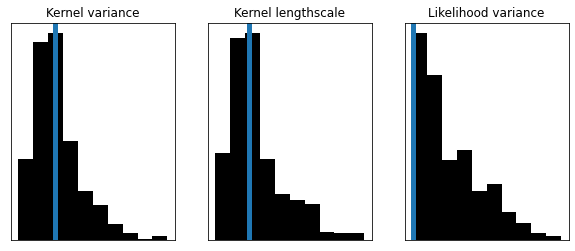

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10,4))
axs[0].hist(post_samps['variance'], color='black');
axs[0].axvline(m.trainable_parameters[0].numpy(), lw=5)
axs[1].hist(post_samps['lengthscales'], color='black');
axs[1].axvline(m.trainable_parameters[1].numpy(), lw=5)
axs[2].hist(post_samps['like_variance'], color='black');
axs[2].axvline(m.trainable_parameters[2].numpy(), lw=5)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])
axs[2].set_xticklabels([])
axs[2].set_yticklabels([])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[0].set_title('Kernel variance')
axs[1].set_title('Kernel lengthscale')
axs[2].set_title('Likelihood variance')

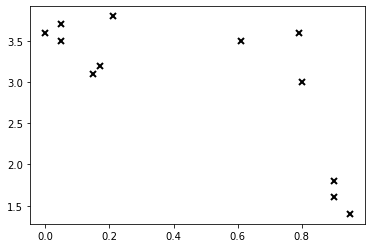

In [ ]:
# data = np.genfromtxt("data/regression_1D.csv", delimiter=",")
# X = data[:, 0].reshape(-1, 1)
# Y = data[:, 1].reshape(-1, 1)

X = np.array([0, 0.05, 0.05, 0.15, 0.17, 0.21, 0.61, 0.79, 0.8, 0.9, 0.9, 0.95]).reshape(-1,1)
Y = np.array([3.6, 3.7, 3.5, 3.1, 3.2, 3.8, 3.5, 3.6, 3.0, 1.8, 1.6, 1.4]).reshape(-1,1)



plt.plot(X, Y, "kx", mew=2);

In [ ]:
k = gpflow.kernels.Matern52()
print_summary(k)

╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Matern52.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Matern52.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛


In [ ]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [ ]:
opt_logs = gpflow.optimizers.Scipy().minimize(m.training_loss, 
                                              m.trainable_variables, 
                                              options=dict(maxiter=100))
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 7.76607   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.492535  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0969323 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

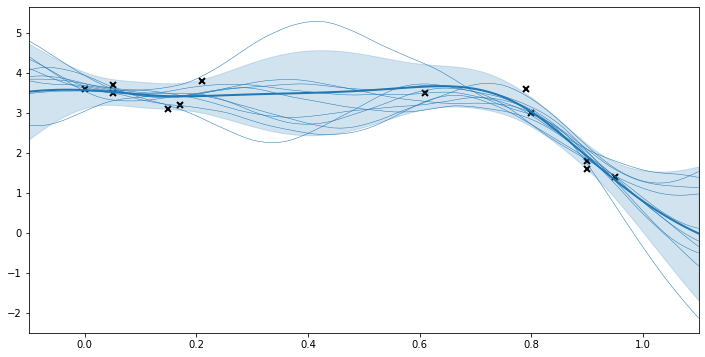

In [ ]:
# Prediction
## generate test points for prediction
xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
_ = plt.xlim(-0.1, 1.1)

